In [451]:
import numpy as np
import pandas as pd
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [452]:
df = pd.DataFrame()

In [453]:
df['X1'] = [1, 2, 3, 4, 5, 6, 6, 7, 9, 9]
df['X2'] = [5, 3, 6, 8, 1, 9, 5, 8, 9, 2]
df['label'] = [1, 1, 0, 1, 0, 1, 0, 1, 0, 0]

In [454]:
df

,X1,X2,label
0,1,5,1
1,2,3,1
2,3,6,0
3,4,8,1
4,5,1,0
5,6,9,1
6,6,5,0
7,7,8,1
8,9,9,0
9,9,2,0


<Axes: xlabel='X1', ylabel='X2'>

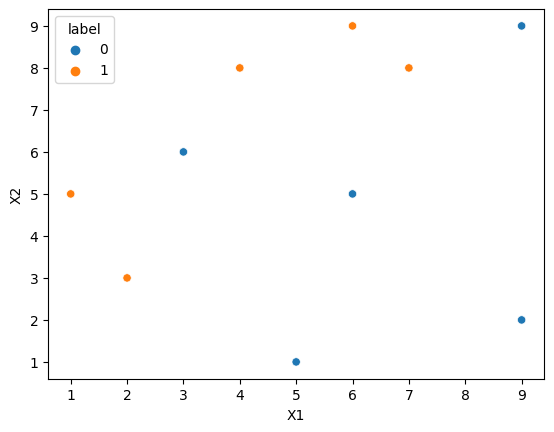

In [455]:
sns.scatterplot(x=df['X1'], y=df['X2'], hue=df['label'])

### step -1 assign weights

In [456]:
df['weights'] = 1/df.shape[0]

In [457]:
df

,X1,X2,label,weights
0,1,5,1,0.1
1,2,3,1,0.1
2,3,6,0,0.1
3,4,8,1,0.1
4,5,1,0,0.1
5,6,9,1,0.1
6,6,5,0,0.1
7,7,8,1,0.1
8,9,9,0,0.1
9,9,2,0,0.1


In [458]:
dt1 = DecisionTreeClassifier(max_depth=1)

In [459]:
X = df.iloc[:, 0:2].values
y = df.iloc[:, 2].values

### Step 2 - Train 1st model

In [460]:
dt1.fit(X, y)

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'x[0] <= 2.5\ngini = 0.5\nsamples = 10\nvalue = [5, 5]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.75, 0.25, 'gini = 0.469\nsamples = 8\nvalue = [5, 3]')]

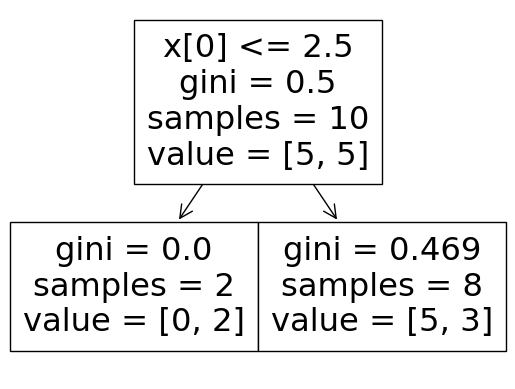

In [461]:
plot_tree(dt1)

<Axes: >

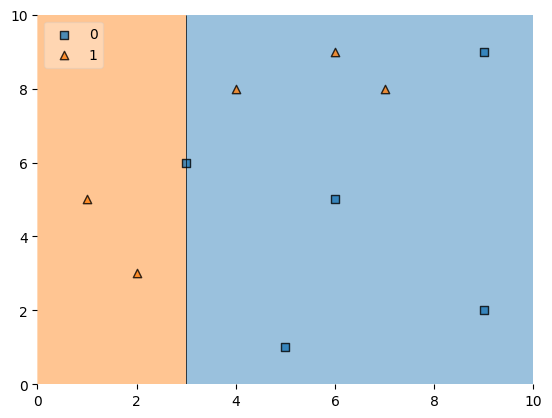

In [462]:
plot_decision_regions(X, y, clf=dt1, legend=2)

In [463]:
df['y_pred'] = dt1.predict(X)

In [464]:
df

,X1,X2,label,weights,y_pred
0,1,5,1,0.1,1
1,2,3,1,0.1,1
2,3,6,0,0.1,0
3,4,8,1,0.1,0
4,5,1,0,0.1,0
5,6,9,1,0.1,0
6,6,5,0,0.1,0
7,7,8,1,0.1,0
8,9,9,0,0.1,0
9,9,2,0,0.1,0


### step 3 - calculate weight 

In [465]:
def calculate_model_weight(error):
    return 0.5*(
        np.log(
            (1-error)
            /
            error+0.0000000000000001
            # 0.0000000000000001
            # to prevent error tend to 0
            # and avoid conflicts
        )
    )

In [466]:
alpha1 = calculate_model_weight(0.3)
alpha1

0.42364893019360184

### step 4 - modify weights 

In [467]:
# correct classification
def update_row_weight(row, alpha=0.423):
    if row['label'] == row['y_pred']:
        # decrease weight
        return row['weights'] * np.exp(-alpha)
    else:
        # increase weight
        return row['weights'] * np.exp(alpha)

In [468]:
# get weights

df['updated_weight_after_m1_pass_to_m2'] = df.apply(
    update_row_weight, axis=1
)
df

,X1,X2,label,weights,y_pred,updated_weight_after_m1_pass_to_m2
0,1,5,1,0.1,1,0.065508
1,2,3,1,0.1,1,0.065508
2,3,6,0,0.1,0,0.065508
3,4,8,1,0.1,0,0.152653
4,5,1,0,0.1,0,0.065508
5,6,9,1,0.1,0,0.152653
6,6,5,0,0.1,0,0.065508
7,7,8,1,0.1,0,0.152653
8,9,9,0,0.1,0,0.065508
9,9,2,0,0.1,0,0.065508


In [469]:
# sum not equal to 1

df['updated_weight_after_m1_pass_to_m2'].sum()

0.9165153319682015

In [470]:
# normalize it to make equal to 1

df['updated_weight_after_m1_pass_to_m2_normalized'] = df['updated_weight_after_m1_pass_to_m2'] / \
    df['updated_weight_after_m1_pass_to_m2'].sum()
df

,X1,X2,label,weights,y_pred,updated_weight_after_m1_pass_to_m2,updated_weight_after_m1_pass_to_m2_normalized
0,1,5,1,0.1,1,0.065508,0.071475
1,2,3,1,0.1,1,0.065508,0.071475
2,3,6,0,0.1,0,0.065508,0.071475
3,4,8,1,0.1,0,0.152653,0.166559
4,5,1,0,0.1,0,0.065508,0.071475
5,6,9,1,0.1,0,0.152653,0.166559
6,6,5,0,0.1,0,0.065508,0.071475
7,7,8,1,0.1,0,0.152653,0.166559
8,9,9,0,0.1,0,0.065508,0.071475
9,9,2,0,0.1,0,0.065508,0.071475


In [471]:
df['updated_weight_after_m1_pass_to_m2_normalized'].sum()

1.0

In [472]:
# right side max value of range
df['comsum_upper'] = np.cumsum(
    df['updated_weight_after_m1_pass_to_m2_normalized']
)
# left side min value of range
df['comsum_lower'] = df['comsum_upper'] - \
    df['updated_weight_after_m1_pass_to_m2_normalized']
df

,X1,X2,label,weights,y_pred,updated_weight_after_m1_pass_to_m2,updated_weight_after_m1_pass_to_m2_normalized,comsum_upper,comsum_lower
0,1,5,1,0.1,1,0.065508,0.071475,0.071475,0.000000
1,2,3,1,0.1,1,0.065508,0.071475,0.142950,0.071475
2,3,6,0,0.1,0,0.065508,0.071475,0.214425,0.142950
3,4,8,1,0.1,0,0.152653,0.166559,0.380983,0.214425
4,5,1,0,0.1,0,0.065508,0.071475,0.452458,0.380983
5,6,9,1,0.1,0,0.152653,0.166559,0.619017,0.452458
6,6,5,0,0.1,0,0.065508,0.071475,0.690492,0.619017
7,7,8,1,0.1,0,0.152653,0.166559,0.857050,0.690492
8,9,9,0,0.1,0,0.065508,0.071475,0.928525,0.857050
9,9,2,0,0.1,0,0.065508,0.071475,1.000000,0.928525


### step - 5 create new dataset

In [473]:
def create_new_dataset(df):
    indices = []
    for i in range(df.shape[0]):
        no = np.random.random()
        for index, row in df.iterrows():
            if row['comsum_upper'] > no and no > row['comsum_lower']:
                indices.append(index)
    return indices

In [474]:
index_values = create_new_dataset(df)
index_values

[5, 8, 8, 5, 5, 3, 6, 4, 5, 0]

In [475]:
second_df = df.iloc[index_values, [0, 1, 2, 3]]
second_df

,X1,X2,label,weights
5,6,9,1,0.1
8,9,9,0,0.1
8,9,9,0,0.1
5,6,9,1,0.1
5,6,9,1,0.1
3,4,8,1,0.1
6,6,5,0,0.1
4,5,1,0,0.1
5,6,9,1,0.1
0,1,5,1,0.1


### step 6 - make another model

In [476]:
dt2 = DecisionTreeClassifier(max_depth=1)

In [477]:
X = second_df.iloc[:, 0:2].values
y = second_df.iloc[:, 2].values

In [478]:
dt2.fit(X, y)

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'x[0] <= 7.5\ngini = 0.48\nsamples = 10\nvalue = [4, 6]'),
 Text(0.25, 0.25, 'gini = 0.375\nsamples = 8\nvalue = [2, 6]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]')]

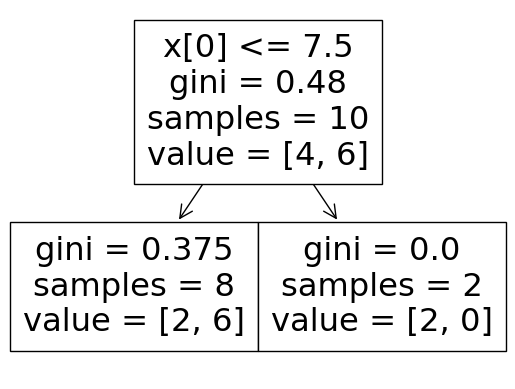

In [479]:
plot_tree(dt2)

<Axes: >

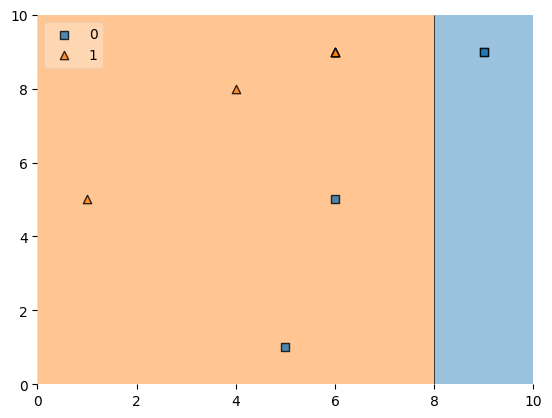

In [480]:
plot_decision_regions(X, y, clf=dt2, legend=2)

In [481]:
second_df['y_pred'] = dt2.predict(X)
second_df

,X1,X2,label,weights,y_pred
5,6,9,1,0.1,1
8,9,9,0,0.1,0
8,9,9,0,0.1,0
5,6,9,1,0.1,1
5,6,9,1,0.1,1
3,4,8,1,0.1,1
6,6,5,0,0.1,1
4,5,1,0,0.1,1
5,6,9,1,0.1,1
0,1,5,1,0.1,1


In [482]:
alpha2 = calculate_model_weight(0.2)
alpha2

0.6931471805599453

In [483]:
# correct classification
def update_row_weight(row, alpha=0.69):
    if row['label'] == row['y_pred']:
        # decrease weight
        return row['weights'] * np.exp(-alpha)
    else:
        # increase weight
        return row['weights'] * np.exp(alpha)

In [484]:
second_df['updated_weight_after_m2'] = second_df.apply(
    update_row_weight, axis=1
)
second_df

,X1,X2,label,weights,y_pred,updated_weight_after_m2
5,6,9,1,0.1,1,0.050158
8,9,9,0,0.1,0,0.050158
8,9,9,0,0.1,0,0.050158
5,6,9,1,0.1,1,0.050158
5,6,9,1,0.1,1,0.050158
3,4,8,1,0.1,1,0.050158
6,6,5,0,0.1,1,0.199372
4,5,1,0,0.1,1,0.199372
5,6,9,1,0.1,1,0.050158
0,1,5,1,0.1,1,0.050158


In [485]:
second_df['updated_weight_after_m2'].sum()

0.800003961901461

In [486]:
second_df['updated_weight_after_m2_normalized'] = second_df['updated_weight_after_m2'] / \
    second_df['updated_weight_after_m2'].sum()
second_df

,X1,X2,label,weights,y_pred,updated_weight_after_m2,updated_weight_after_m2_normalized
5,6,9,1,0.1,1,0.050158,0.062697
8,9,9,0,0.1,0,0.050158,0.062697
8,9,9,0,0.1,0,0.050158,0.062697
5,6,9,1,0.1,1,0.050158,0.062697
5,6,9,1,0.1,1,0.050158,0.062697
3,4,8,1,0.1,1,0.050158,0.062697
6,6,5,0,0.1,1,0.199372,0.249213
4,5,1,0,0.1,1,0.199372,0.249213
5,6,9,1,0.1,1,0.050158,0.062697
0,1,5,1,0.1,1,0.050158,0.062697


In [487]:
second_df['updated_weight_after_m2_normalized'].sum()

1.0

In [488]:
# right side max value of range
second_df['comsum_upper'] = np.cumsum(
    second_df['updated_weight_after_m2_normalized']
)
# left side min value of range
second_df['comsum_lower'] = second_df['comsum_upper'] - \
    second_df['updated_weight_after_m2_normalized']
second_df

,X1,X2,label,weights,y_pred,updated_weight_after_m2,updated_weight_after_m2_normalized,comsum_upper,comsum_lower
5,6,9,1,0.1,1,0.050158,0.062697,0.062697,0.000000
8,9,9,0,0.1,0,0.050158,0.062697,0.125393,0.062697
8,9,9,0,0.1,0,0.050158,0.062697,0.188090,0.125393
5,6,9,1,0.1,1,0.050158,0.062697,0.250787,0.188090
5,6,9,1,0.1,1,0.050158,0.062697,0.313483,0.250787
3,4,8,1,0.1,1,0.050158,0.062697,0.376180,0.313483
6,6,5,0,0.1,1,0.199372,0.249213,0.625393,0.376180
4,5,1,0,0.1,1,0.199372,0.249213,0.874607,0.625393
5,6,9,1,0.1,1,0.050158,0.062697,0.937303,0.874607
0,1,5,1,0.1,1,0.050158,0.062697,1.000000,0.937303


In [489]:
index_values = create_new_dataset(second_df)
index_values

[5, 0, 5, 5, 5, 3, 6, 4, 6, 5]

In [490]:
third_df = second_df.iloc[index_values, [0, 1, 2, 3]]
third_df

,X1,X2,label,weights
3,4,8,1,0.1
5,6,9,1,0.1
3,4,8,1,0.1
3,4,8,1,0.1
3,4,8,1,0.1
5,6,9,1,0.1
6,6,5,0,0.1
5,6,9,1,0.1
6,6,5,0,0.1
3,4,8,1,0.1


In [491]:
dt3 = DecisionTreeClassifier(max_depth=1)

In [492]:
X = second_df.iloc[:, 0:2].values
y = second_df.iloc[:, 2].values

In [493]:
dt3.fit(X, y)

DecisionTreeClassifier(max_depth=1)

<Axes: >

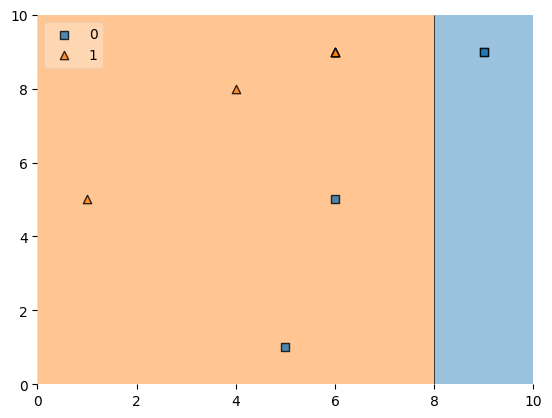

In [494]:
plot_decision_regions(X, y, clf=dt3, legend=2)

In [495]:
third_df['y_pred'] = dt3.predict(X)
third_df

,X1,X2,label,weights,y_pred
3,4,8,1,0.1,1
5,6,9,1,0.1,0
3,4,8,1,0.1,0
3,4,8,1,0.1,1
3,4,8,1,0.1,1
5,6,9,1,0.1,1
6,6,5,0,0.1,1
5,6,9,1,0.1,1
6,6,5,0,0.1,1
3,4,8,1,0.1,1


In [496]:
alpha3 = calculate_model_weight(0.5)
alpha3

0.0

In [497]:
print(alpha1, alpha2, alpha3)

0.42364893019360184 0.6931471805599453 0.0


In [498]:
query = np.array([1, 5]).reshape(1, 2)
query

array([[1, 5]])

In [499]:
dt1.predict(query)

array([1], dtype=int64)

In [500]:
dt2.predict(query)

array([1], dtype=int64)

In [501]:
dt3.predict(query)

array([1], dtype=int64)

In [514]:
alpha1*(1) + alpha2*(-1) + alpha3*(1)

-0.26949825036634345

In [515]:
np.sign(0.45)

1.0

In [508]:
query = np.array([9, 9]).reshape(1, 2)
query

array([[9, 9]])

In [509]:
dt1.predict(query)

array([0], dtype=int64)

In [510]:
dt2.predict(query)

array([0], dtype=int64)

In [511]:
dt3.predict(query)

array([0], dtype=int64)

In [516]:
alpha1*(-1) + alpha2*(-1) + alpha3*(1)  # for 0 do -1

-1.1167961107535471

In [517]:
np.sign(-1.1)

-1.0